## Using Buffers for Local Raster Analysis
#### GPHY 489 - Programming for GIS | Midterm Project | 2024-03-14
#### Bryce Young | by197116

**Background**

My master's thesis research involves wildfire risk analysis to individual homes/structures. This requires characterizing the area immediately surrounding a particular home to ascertain its potential to transmit fire to the structure itself. This area is known as the "Home Ignition Zone" or HIZ, and can include - for example - vegetation and adjacent homes. Certain metrics such as vegetation height and NDVI can provide information about the features of the vegetation within a home's HIZ, and this information is commonly stored in rasters.

In this tutorial, I will describe the process of creating a simplified HIZ for each home in a county using GeoPandas, and displaying the results on an interactive Folium map. With this HIZ, we will characterize the vegetation within it using average NDVI per zone. This principle can be extended to any geometry and any associated raster values, so let's challenge ourselves to think outside the scope of this project and consider other applications of this workflow!

**Data and Packages**

The primary Python package used in this tutorial is [GeoPandas](https://geopandas.org/en/stable/docs.html), which enables us to store georeferenced polygons and attach data to each polygon, exactly as you would with an ESRI Shapefile. This is an excellent package for this project, because we want to take the characteristics of a raster that immediately surrounds an individual structure, and append those characteristics to the structure for future risk analysis. We will explore the geometries on an interactive [Folium](https://pypi.org/project/folium/) map. We will manipulate and analyze rasters using the [Rasterio](https://rasterio.readthedocs.io/en/latest/api/rasterio.html) package.

Microsoft Building Footprints can be downloaded [at this link](https://www.microsoft.com/en-us/maps/bing-maps/building-footprints).

The building footprints can be filtered by county. I filtered for Gunnison County, Colorado, which is our area of interest in this tutorial.

----
#### 1. Read in the data
Here, we're reading in the Planet satellite imagery and shapefile of building footprints from the Microsoft Building Footprint dataset. We're then using the projected coordinate reference system (CRS) of the satellite imagery as the CRS for the building footprints.

In [2]:
import geopandas as gpd
import rasterio as rio

ds = rio.open('C:/Users/by197116/Documents/Projects/GUC_ParcelLevelRisk/Data/Planet Satellite/Planet_CrestBut_20230709/composite.tif')
gdf = gpd.read_file('C:/Users/by197116/Documents/Projects/GUC_ParcelLevelRisk/Data/Gunnison_County_Buildings/Gunnison_County_Buildings.shp')

# Define common CRS
CRS = ds.crs

# Project coordinate system
gdf = gdf.to_crs(CRS) # Apply the CRS that aligns with our raster data

print(gdf.crs)

PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


---
#### 2. Creating Buffers around Geometries

Since we are interested in the area immediately surrounding the building footprint, let's create a buffered area around each building footprint and save the buffers as geometries that we can later use to clip out rasters and do local analysis.

Fortunately, this only requires one argument in GeoPandas!

In [3]:
D = 50 # Default values are in meters. Adjust this distance as needed.

gdf['buffer'] = gdf.buffer(distance = D)

gdf.head()

,FID,County,geometry,buffer
0,3963,Gunnison County,"POLYGON ((367206.929 4305093.004, 367207.014 4...","POLYGON ((367207.767 4305142.997, 367212.586 4..."
1,12567,Gunnison County,"POLYGON ((338997.843 4284518.248, 338998.711 4...","POLYGON ((338992.735 4284468.510, 338987.887 4..."
2,12568,Gunnison County,"POLYGON ((338821.585 4281661.521, 338830.729 4...","POLYGON ((338776.874 4281639.138, 338774.897 4..."
3,12569,Gunnison County,"POLYGON ((336846.711 4277951.954, 336845.214 4...","POLYGON ((336852.094 4278001.663, 336856.945 4..."
4,12570,Gunnison County,"POLYGON ((336834.673 4277567.392, 336832.153 4...","POLYGON ((336849.622 4277615.105, 336854.204 4..."


It's good to keep in mind that this doesn't apply only to building footprints. You can set geometries to any area of interest: a sample site, a fire line, a POD boundary. The buffer function can be used to create a very localized area of interest in which you can perform local analysis on any local characteristic that's available in a raster (e.g. NDVI, EVI, vegetation height, etc.)!

---
#### 3. Visualizing Geometries on an Interactive Map with Folium

One of my favorite mapping functions in Python is **Folium**. Folium is a Python implementation of a Leaflet map, which is a functional interactive map with a lot of options for customization. The advantage of this package is display and aesthetics.

More on Folium can be found here: https://pypi.org/project/folium/
More on Leaflet can be found here: https://leafletjs.com/

If you haven't installed Folium before, go to the command line and type:

```pip install folium```

Now, let's create a simple map!

A Folium map is typically initiated with `m = folium.Map()`. This requires two arguments: `location` and `zoom_start`. This will control the initial display of your map. Let's create a map centered in Crested Butte, Colorado. If you assigned `m` as the map variable, simply type `m` to display the interactive map.

If you want to change the basemap, simply pass the argument `tiles = 'name of basemap'` within `folium.Map()`. Choose one from https://leaflet-extras.github.io/leaflet-providers/preview/.

In [ ]:
import folium

ZOOM = 14
CENTER_COORD = [38.872140, -106.984432]

m = folium.Map(location = CENTER_COORD, zoom_start = ZOOM)

m

Notice how you can zoom and pan around the map intuitively, just like you would do in common programs like Google Maps or ArcGIS Pro. This can be useful if you're looking at visualizing and exploring values in an area!

Now that we have created a map `m`, we can add our building footprints and buffers to the map.

Folium like GeoJson formats. It's easy to convert a GeoPandas GeoSeries (i.e. a column in a GeoDataFrame) to GeoJson with `folium.GeoJson(GEOSERIES_VARIABLE)`.

When you add styling to your GeoJson map layers, Folium likes the form `style_function = lambda feature: {}` where you pass a dictionary with keys such as 'fillColor'. 

Much like matplotlib.pyplot, each element of the map needs a label if it is going to appear on a legend. The labeling argument within folium.GeoJson is `name = 'layer_name`.

Finally, each layer that you create needs to be added to the map. The entire simplified function looks like this: `folium.GeoJson(GEOSERIES, name = 'myGeoSeries').add_to(m)`

In [ ]:
# Global Variables
BUILDINGS = gdf['geometry']
BUFFER = gdf['buffer']

# Add the building footprints to the map
folium.GeoJson(
    BUILDINGS,
    style_function=lambda feature: {
        'color': 'steelblue',
        'weight': 2,
        'fillColor': 'steelblue',
        'fillOpacity': 0.5,
    },
    name='Buildings',
).add_to(m)

# Add the buffers to the map
folium.GeoJson(
    BUFFER,
    style_function=lambda feature: {
        'color': 'orchid',
        'weight': 1,
        'fillColor': 'orchid',
        'fillOpacity': 0.3,
    },
    name='HIZ',
).add_to(m)

# Add layer control to toggle on/off
folium.LayerControl().add_to(m)

# Display the map
m

---
#### 4. Share the Map to our Colleagues or Clients

One of the best parts about Folium maps are that they are user friendly and easily shareable. Since our map is called `m`, we can simply save it with `m.save('filename.html')`. This file can easily be attached to an email where someone can open it and see your beautiful, interactive map in a web browser. 

I know, I know, this is a pretty short code snippet to dedicate an entire section of the tutorial. Grad students and developers have to be so focused on doing good work, that for many of us it goes unnoticed that our work has so much more **impact** if we can **share** it with people. Publishing is an easily evidenced example, but we know that publications will only reach so many people. We need to be able to communicate our work to a wide variety of audiences, clients and potential employers, share ideas with colleagues and mentors, and create environments for collaboration and exploration. For these reasons, I highly recommend that everybody spends time learning how to share their ideas and results in a variety of user-friendly formats!

In [24]:
m.save("my_map.html")  # Save the map as an HTML file

---
#### 5. Overview of Reading and Working with Raster Data

This is good to know, but how does it help with spatial analysis? As mentioned earlier, one of the most common ways that an analyst may want to use the `buffer` function and create a map is to analyze raster values within the buffers.

Let's say I'm interested in the characteristics of the vegetation within each buffer. The buffers on our map are a simplified version of a "Home Ignition Zone" or HIZ. Within the HIZ, we are interested in characterizing the vegetation by height, density, moisture and proximity to the home in order to understand its impact on the home's vulnerability to wildfire. This information can be obtained from aerial imagery and LiDAR; both options can be rasterized and analyzed. Challenge: Can you think of options that apply to your work?

I downloaded some high resolution (3m) satellite imagery from https://www.planet.com/ using an educational license. Planet is a private company with very high data acquisition costs, but they offer free access through institutions like University of Montana. Satellite imagery through educational access consists of 4 bands: blue, green, red and NIR, and can be obtained nearly every day of the year for an arbitrary area of interest!

The `rasterio.open()` function takes a string file path and returns an opened dataset object. 

In [5]:
import rasterio as rio

ds = rio.open('C:/Users/by197116/Documents/Projects/GUC_ParcelLevelRisk/Data/Planet Satellite/Planet_CrestBut_20230709/composite.tif')

Data can be accessed per band by a band's index number. Following GDAL convention, bands are indexed from 1, so the first band would be `ds.read(1)`.

From Planet's documentation, we know that there are 4 bands. We can confirm with `ds.count`. We can also get spatial information with `ds.width` and `ds.height`.

These are the bands:
- Band 1: Blue
- Band 2: Green
- Band 3: Red
- Band 4: NIR

In [6]:
ds.count

4

In [7]:
ds.width

6070

In [8]:
ds.height

9386

Now let's use matplotlib.pyplot to display the blue band array.

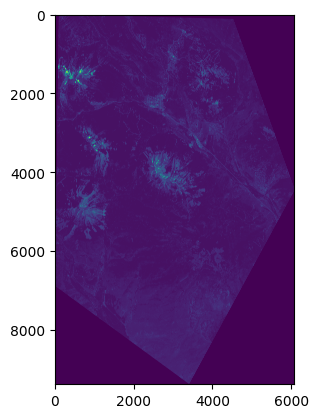

In [10]:
import matplotlib.pyplot as plt

blue = ds.read(1)

plt.imshow(blue)

It may be difficult to see if you don't know what you're looking for, but it's apparent from the plot above that values with no data are set to some value. We can see what that value is with `ds.nodata`

In [12]:
ds.nodata

0.0

This is a strange 'nodata' value! It's strange because there is a possibility that the value of some of the pixels is, in fact, 0.0. This could result is removing real data from the image if we replace 0.0 valued pixels with np.nan. Since this is just a demonstration, we're not going to worry about it for now.

The bands we extract with `ds.read()` are saved as NumPy arrays, which makes them easy to manipulate and perform mathematical operations on. We can 'remove' the areas of the plot where there is no satellite image data by altering the NumPy array directly, as shown below:

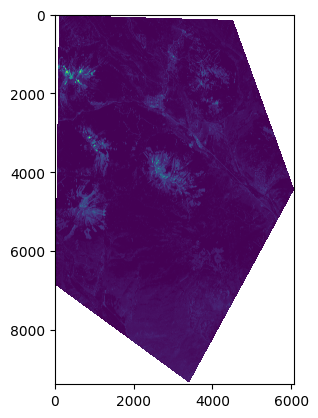

In [15]:
import numpy as np

blue = np.where(blue == 0.0, np.nan, blue)

plt.imshow(blue)

Now that we're somewhat familiar with our dataset and how we can work with it using Rasterio, we're going to label the NIR and Red bands, and use them to calculate NDVI. For this tutorial, we're not going to worry about the Blue or Green bands. We're interested in calculating NDVI, given by the following equation:

$ NDVI = \frac{NIR - Red}{NIR + Red} $

Keep in mind that the `read()` method returns a NumPy array, so mathematical operations with multiple bands is a cinch!

In [16]:
# Label the raster bands and calculate NDVI

red = ds.read(3)
nir = ds.read(4)

def calculate_ndvi(red, nir):
    ndvi = (nir - red)/(nir + red)
    return ndvi

ndvi = calculate_ndvi(red, nir)

C:\Users\by197116\AppData\Local\Temp\ipykernel_8480\2636271177.py:7: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red)/(nir + red)


We have just created a NumPy array called `ndvi`. Now we can show our NDVI values in an image representing our area of interest using the `plt.imshow()` function.

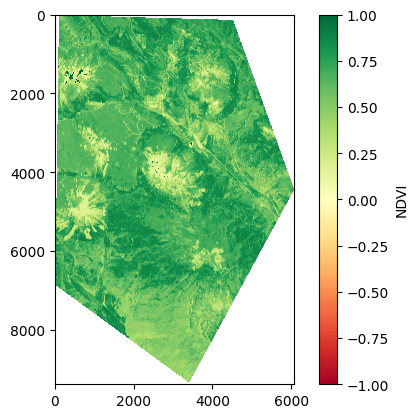

In [17]:
plt.imshow(ndvi, cmap='RdYlGn', clim = (-1,1))
plt.colorbar(label = 'NDVI')
plt.show()

Now let's close the dataset. Closing the dataset saves any changes to the disk. In this case, we've just gone over some basics, and now we're closing the dataset because we want to work with the buffers we created earlier to mask this ndvi array.

In [19]:
ds.close() # Close the dataset
ds.closed  # Check if the dataset in, in fact, closed

True

---
#### 6. Clipping/Masking a Raster to your Multipolygon or GeoSeries Geometry

The problem with the array that we just created is that it is an *array*, which we cannot assign CRS or an affine transformation. The trick here is to save the array as a Rasterio dataset. However, that can be a little cumbersome if we have to save it as a GeoTIFF and then reopen it. Fortunately, Rasterio has a way to store the dataset as a temporary file that is stored on your computer's RAM, which is faster to work with than the disk, and allows us to treat ndvi like its own GeoTIFF!

The code block below opens the satellite image dataset, creates an NDVI GeoTIFF, temporarily stores the GeoTIFF on RAM, masks the NDVI GeoTIFF, and returns an array and transformation of the masked GeoTIFF.

In [62]:
from rasterio.mask import mask
from rasterio.io import MemoryFile

# Open the dataset
with rio.open('C:/Users/by197116/Documents/Projects/GUC_ParcelLevelRisk/Data/Planet Satellite/Planet_CrestBut_20230709/composite.tif') as ds:

    # Read the specific bands for NDVI calculation
    nir = ds.read(4)  # NIR band is the fourth band
    red = ds.read(3)  # Red band is the third band

    # Calculate NDVI
    ndvi = calculate_ndvi(red, nir)

    # Prepare geometries from GeoDataFrame for masking
    geoms = gdf_p['buffer'].values

    # Create a new in-memory dataset for NDVI
    with MemoryFile() as memfile:
        # Define new dataset metadata: single band, floating point data
        meta = ds.meta.copy()
        meta.update(count=1, dtype='float32')

        with memfile.open(**meta) as ndvi_dataset:
            # Write NDVI array to in-memory dataset
            ndvi_dataset.write(ndvi, 1)

            # Apply the mask using the geometries
            out_values, out_transform = mask(ndvi_dataset, geoms, crop=True, nodata = np.nan)

C:\Users\by197116\AppData\Local\Temp\ipykernel_11100\286961358.py:7: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red)/(nir + red)


It's a lot for one code block! So let's go through the code block below, step by step:

1. **Opening the dataset:** We already saw that datasets have to be opened and closed. If we follow the convention of `with rio.open('filepath.tif') as ds`, then we can nest our code in the `with` statement and assume that the file will close automatically.
2. **Calculating NDVI:** This should be familiar to you from the above example.
3. **Getting our geometries:** Recall `gdf_p['buffer']` is the GeoSeries where each row is a Shapely object, and each object is a geometry that represents a buffer around a building footprint. For the `rio.mask()` function to access these Shapely objects, the objects need to be stored in an array. We achieve this by simply apending `.values` to the GeoSeries, which stores the Shapely geometries in an array. Rasterio loves geometries that are in arrays!
4. **Create a temporary file to store NDVI raster data:** When `MemoryFile()` is called, it creates a new **in-memory file object**. This object will be used to store the NDVI raster data temporarily.
5. **Using the in-memory file object:** The `with memfile.open(**meta) as ndvi_dataset:` line opens this in-memory file as a new Rasterio dataset. The `**meta` argument passes the metadata (such as CRS, data type, and dimensions) from the original dataset to ensure consistency. This newly opened dataset behaves just like a dataset opened from a file on disk but is stored in memory. But there's no data to do anything with yet! `ndvi_dataset.write(ndvi, 1)` writes the NDVI data into the first band of the new in-memory dataset. At this point, the NDVI data is stored in the MemoryFile, ready for further operations like masking.
6. **Applying the mask:** The `mask` function is then applied to the in-memory NDVI dataset. This function takes `ndvi_dataset`, crops it with the all the shapes in `geoms`, and sets anything outside the cropped area to `np.nan`. The masked result is written into `out_values`, which we can later use for analysis or visualization.

Take your time to understand this!

---
#### 7. Plotting the Clipped/Masked Raster

Now the easy part, let's plot `out_values` and admire the results of our hard work. We may have to adjust the shape of `out_values` with `np.squeeze()` in order to visualize the data on a 2D plot

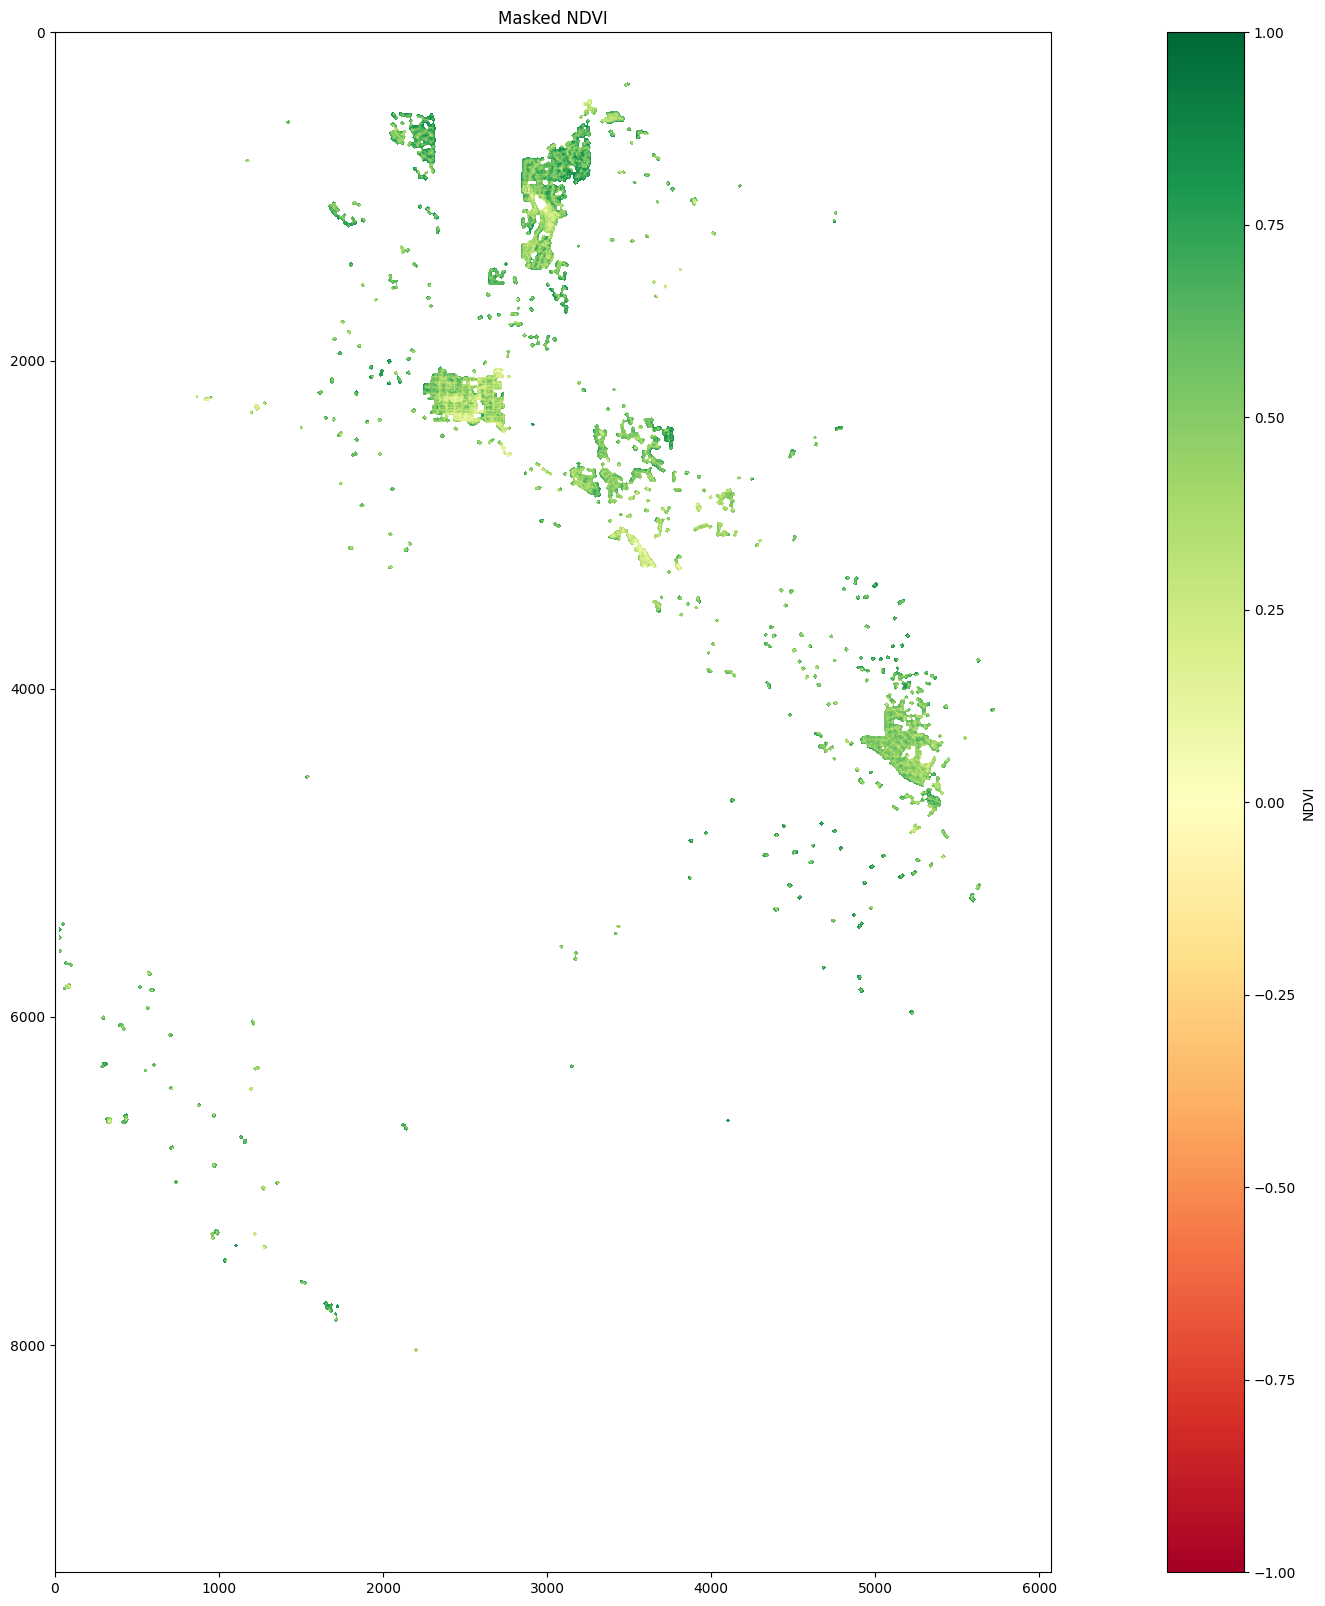

In [68]:
# Now let's plot the NDVI data
plt.figure(figsize=(30, 20))
# Use np.squeeze to get rid of the single-dimensional entry from the shape of the array
# out_values.shape =  (1, 9386, 6070). (np.squeeze(out_values)).shape = (9386, 6070)
plt.imshow(np.squeeze(out_values), cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')  # Show a color bar with label
plt.title('Masked NDVI')  # Add a title to the plot
plt.show()

The intention of this tutorial was to display the results on Folium for visualization. However, Folium does not easily handle raster data. So I am ommitting this section. Anyways, it's only for fun. The serious work happens in our **analysis**!

---
#### 8. Analyzing Raster Values per Polygon in the Dataset

Recall that `gdf_p` contains geometries for 13,000 building footprins and their 50m buffers. We have just created a raster that represents the NDVI value per 3m pixel within each 50m buffer. For the purposes of reducing wildfire risk to individual homes, it's important that we analyze raster values within each parcel or buffer zone. GeoPandas - once again - really comes in handy for this task. While there are more information-rich data than NDVI, let's stick with the theme and assume that we are getting really valuable information from **average NDVI per parcel**.

Our workflow for this calculation - written in plain English - is as follows:
1. **Mask raster with geometries**: Recall that `gdf_p['buffer']` is a geoseries of Shapely geometries. We need to iterate through **each** of these 13,000 objects and use them to mask our raster, one by one.
2. **Calculate average NDVI**: once the mask is applied to only include a single building buffer, we'll take the average of all the pixels in the area. 
3. **Store NDVI per parcel as a new column in `gdf_p`:** The average NDVI will be stored as `gdf_p['ndvi']` and each value will correspond to the geometry in the same row.

Let's see how the code works.

In [72]:
from rasterio.features import geometry_mask

# Reminder: 'out_values' is our NDVI array and 'out_transform' is the affine transform,
# 'gdf_p' is our GeoDataFrame, and it has a 'buffer' column with our geometries.

# Create a new list to store the average NDVI values
avg_ndvi = []

# Iterate through each geometry in the 'buffer' column
for geom in gdf_p['buffer']:
    # Create a mask for the current geometry, True outside the geometry, False inside
    geom_mask = geometry_mask([geom], transform = out_transform, invert = True, out_shape = (np.squeeze(out_values)).shape

    # Use the mask to select NDVI values within the geometry
    ndvi_within_geom = np.where(geom_mask, np.nan, out_values[0])
    
    # Calculate the average NDVI, ignoring nan values
    avg_ndvi_value = np.nanmean(ndvi_within_geom)
    
    # Append the average NDVI to the list
    avg_ndvi.append(avg_ndvi_value)

# Add the average NDVI values as a new column in the GeoDataFrame
gdf_p['ndvi'] = avg_ndvi


In [73]:
gdf_p.head()

,FID,County,geometry,buffer,ndvi
0,3963,Gunnison County,"POLYGON ((367206.929 4305093.004, 367207.014 4...","POLYGON ((367207.767 4305142.997, 367212.586 4...",0.537487
1,12567,Gunnison County,"POLYGON ((338997.843 4284518.248, 338998.711 4...","POLYGON ((338992.735 4284468.510, 338987.887 4...",0.537487
2,12568,Gunnison County,"POLYGON ((338821.585 4281661.521, 338830.729 4...","POLYGON ((338776.874 4281639.138, 338774.897 4...",0.537487
3,12569,Gunnison County,"POLYGON ((336846.711 4277951.954, 336845.214 4...","POLYGON ((336852.094 4278001.663, 336856.945 4...",0.537487
4,12570,Gunnison County,"POLYGON ((336834.673 4277567.392, 336832.153 4...","POLYGON ((336849.622 4277615.105, 336854.204 4...",0.537487


---
#### 9. Conclusion

**Eureka!** We now have average NDVI values for each home ignition zone in Gunnison County, Colorado! The NDVI values are associated with each building footprint, so we can analyze each individually on a map, and can export to colleagues or clients. If you don't yet see the benefits of GeoPandas in this case, let me explain. Saving your new GeoDataFrame to disk, we now have a shapefile containing building footprints, home ignition zones, and raster attributes of each zone. When we add this to a map in ArcGIS Pro, we can click on a home on a map and immediately see the values associated with that home and its home ignition zone. How tall are the trees? How close are they to the house? How dense is the vegetation? We're essentially doing a remote risk assessment of each building site!

Let's not forget that **ANY** raster can be used in this workflow, and **ANY** geometry can be used! If you're in the wildfire space, consider using this workflow to obtained detailed information around sections of a POD boundary. If you're more of an ecologist, consider using this workflow to collect immediate environmental characteristics of your randomly selected data collection sites in the field. 

Thanks for following my tutorial! I hope you put this information to good use. Stay tuned for taking this method a step further!

In [80]:
gdf_p['ndvi'].min()

0.5368547439575195

In [81]:
gdf_p['ndvi'].max()

0.5383542776107788

Note: those NDVI values sure seem incorrect! This is something that I'm going to have to troubleshoot!